In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'    # GPU No.
from sampler.utils import *
from trainer.utils import restore_checkpoint
import torch
import torch.nn as nn
import json
from collections import namedtuple
from tqdm import tqdm

from models import get_model, get_ema
from sampler import VESDE
import numpy as np
from einops import rearrange

data_name = 'era5'
version = 'v0'      
opt_path = './results/' + data_name + '_' + version + '/config.json'
with open(opt_path, 'r', encoding='utf-8') as f:
    opt = json.load(f)
    opt['num_channels'] = opt['num_components'] + opt['num_conditions']
OPT_class = namedtuple('OPT_class', opt.keys())
opt = OPT_class(**opt)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

2025-04-09 15:32:44.351817: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Load pretrained model

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = get_model(opt)
net = nn.DataParallel(net)
net.to(device)
ema = get_ema(net.parameters(), decay=opt.ema_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=opt.lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
state = dict(optimizer=optimizer, model=net, ema=ema, epoch=0, iteration=0, loss_train=[])

ckpt_path = opt.results_path + '/checkpoint.pth'

state = restore_checkpoint(ckpt_path, state, device)
net = state['model']
ema = state['ema']
ema.copy_to(net.parameters())
print('Model loaded from epoch', state['epoch'])

Model loaded from epoch 98


# Load test data

In [3]:
data_test_path = "./data/era5/era5_test.npy"
data_raw = np.load(data_test_path)
_, z = np.meshgrid(np.linspace(0, 2 * np.pi, opt.image_size, endpoint=False),
                    np.linspace(0, 2 * np.pi, opt.image_size, endpoint=False), indexing='ij')
x_test = data_raw.transpose(0, 1, 4, 2, 3)
print(x_test.shape)

(1, 273, 4, 64, 64)


# Load test data

In [4]:
m           =   2                                       # overlap
T           =   opt.num_frames                          # number of frames within a single sample
T_prime     =   100                                      # length of frames you want to generate
B           =   int(np.ceil((T_prime-m) / (T - m)))     # number of samples for parallel generation
T_prime     =   B * (T - m) + m                         # the total length might be a little longer than the given length
n_samples   =   1                                       # batch size

samples = []
seed_samples = 1
rnd = np.random.RandomState(seed_samples)
num_re = len(x_test)
num_k = len(x_test[0])
s_re, s_k = 4, 0

'''experimental samples'''
t_start = 0
samples = x_test[:, t_start:t_start+T_prime]
print(samples.shape)

(1, 106, 4, 64, 64)


# Reconstruction

In [5]:
outer_loop = 1000    # predictor steps

seed_sample = 123

obs_type = 'random'     # 'random', 'regular', 'forecast'
scale = 0.99            # scale is: mask ratio (float between 0 and 1, e.g., 0.98) for 'random', down-sampling rate (int, e.g., 8) for 'regular', number of initial frames (int, e.g., 2) for 'forecast'

# hyperparameters for generating stage
alpha_case = 0.1
beta = 0.4
gamma = 0.5

'''for Kolmogorov flow'''
sde = VESDE(opt, sigma_min=opt.beta_min, sigma_max=opt.beta_max, N=outer_loop)
net.eval()
reap_fn = lambda x, num: torch.stack([x for _ in range(num)])

setup_seed(seed_sample)
with torch.no_grad():
    if obs_type.lower() == 'random':
        '''randomly located observation'''
        T_prime_y = T_prime                      # sequence that is dependent on observation
        mask = np.zeros([opt.num_components+opt.num_conditions, opt.image_size, opt.image_size])
        mask[:opt.num_components] = mask_gen([1, opt.image_size, opt.image_size], scale, seed=seed_samples)
        mask_torch = torch.from_numpy(mask).to(device)
        transform_gen = transform = lambda x:x[:, :T_prime_y]*mask[np.newaxis, np.newaxis] if isinstance(x, np.ndarray) else x[:, :T_prime_y]*mask_torch[None, None].to(x.device)   # only the observable frames are given
        sparsity = scale            # calculate sparsity of each task
    elif obs_type.lower() == 'regular':
        '''regularly located observation'''
        T_prime_y = T_prime
        transform_gen = transform = lambda x:x[:, :T_prime_y, :, ::scale, ::scale]     # only the observable frames are given
        sparsity = 1-1/scale**2     # calculate sparsity of each task
    elif obs_type.lower() == 'forecast':
        T_prime_y = 0
        transform_gen = transform = lambda x:x[:, :scale]
        sparsity = 1-scale/T        # calculate sparsity of each task

    alpha = alpha_case/np.sqrt(1-sparsity)
    
    samples_scale = samples.copy()
    # samples_scale[:, :, :opt.num_components] = scalar(samples_scale[:, :, :opt.num_components])
    y = transform_gen(samples_scale)
    print(y.shape)

    latent_mask = torch.ones([T, 1, 1, 1]).float().to(device)
    obs_mask = torch.zeros([T, 1, 1, 1]).float().to(device)
    frame_indices = torch.arange(T).to(device)
    net_fn = lambda x, t: net(x, x0=x, timesteps=t, latent_mask=reap_fn(latent_mask, len(x)), obs_mask=reap_fn(obs_mask, len(x)), frame_indices=reap_fn(frame_indices, len(x)))[0]

    x_inpainted = s3gm_sample_2d(opt, net_fn, sde, y,
                              transform_gen,
                              alpha=alpha, beta=beta, gamma=gamma,
                              T_prime_y=T_prime_y, T_prime=T_prime, overlap=m,
                              corrector=NoneCorrector,
                              snr=0.128, device=device, dtype='float', eps=1e-12,
                              probability_flow=False, continuous=True,)

x_pred = x_inpainted
# x_pred[:, :, :opt.num_components] = scalar_inv(x_pred[:, :, :opt.num_components])
num_T = x_pred.shape[1]
print(f'Number of generated snapshots: {num_T}')
torch.cuda.empty_cache()

(1, 106, 4, 64, 64)


loss total: 4.14194e+01 | loss obs.: 1.00127e+00 | loss consis.: 4.04181e+01: 100%|██████████| 1000/1000 [04:28<00:00,  3.72it/s]

Number of generated snapshots: 106


# Visualization

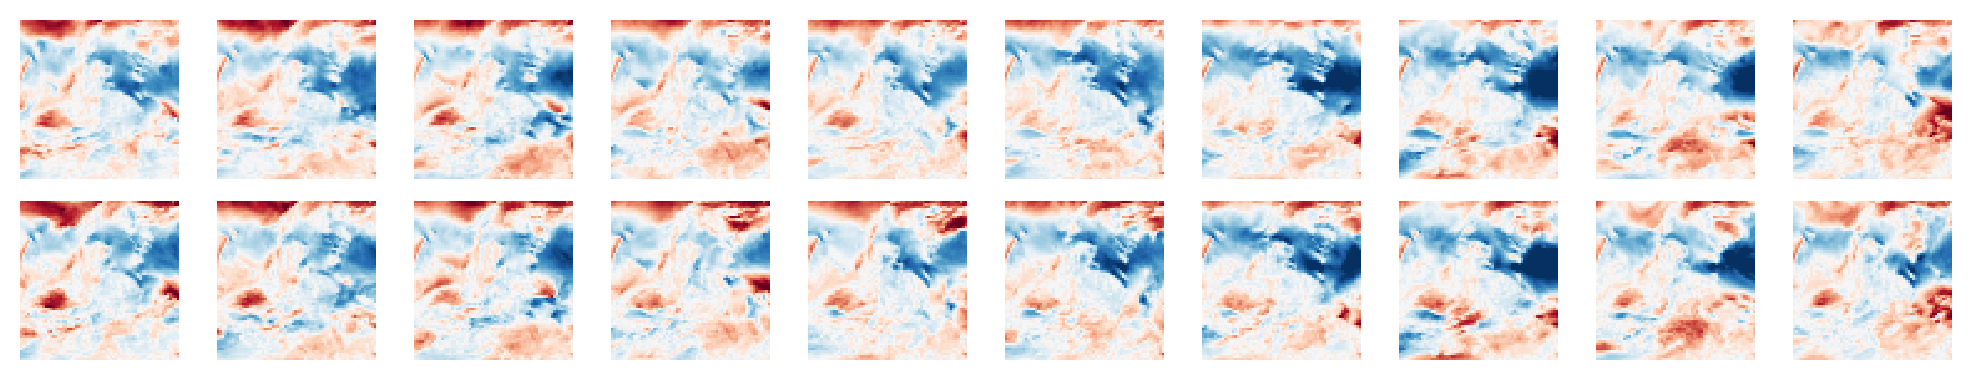

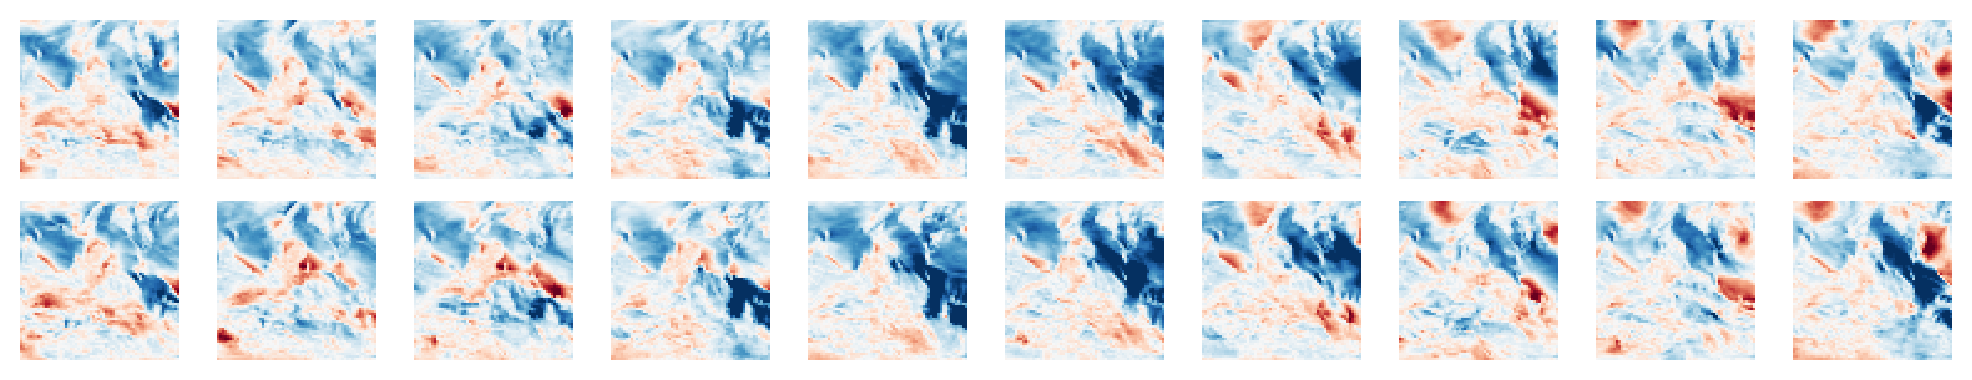

In [6]:
from einops import rearrange
i_start = 40
length  = 10
plot_field(np.concatenate([x_pred[0, i_start:i_start+length, 0], samples[0, i_start:i_start+length, 0]]), 2, length, dpi=200, q_range=[-3, 3])  # 1st component of velocity
plot_field(np.concatenate([x_pred[0, i_start:i_start+length, 1], samples[0, i_start:i_start+length, 1]]), 2, length, dpi=200, q_range=[-3, 3])  # 2nd component of velocity

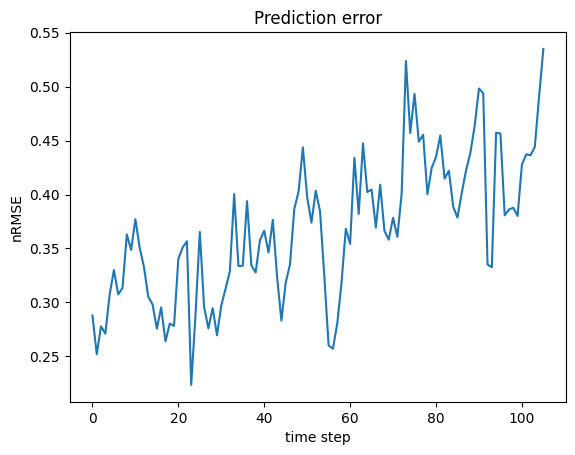

In [7]:
errors = cal_rmse(samples[0], x_pred[0], normalize=True)
plt.plot(errors)
plt.xlabel('time step')
plt.ylabel('nRMSE')
plt.title('Prediction error')
plt.show()

# GIF of the generated field
Please check './results/test_kol.gif' for the generated GIF!

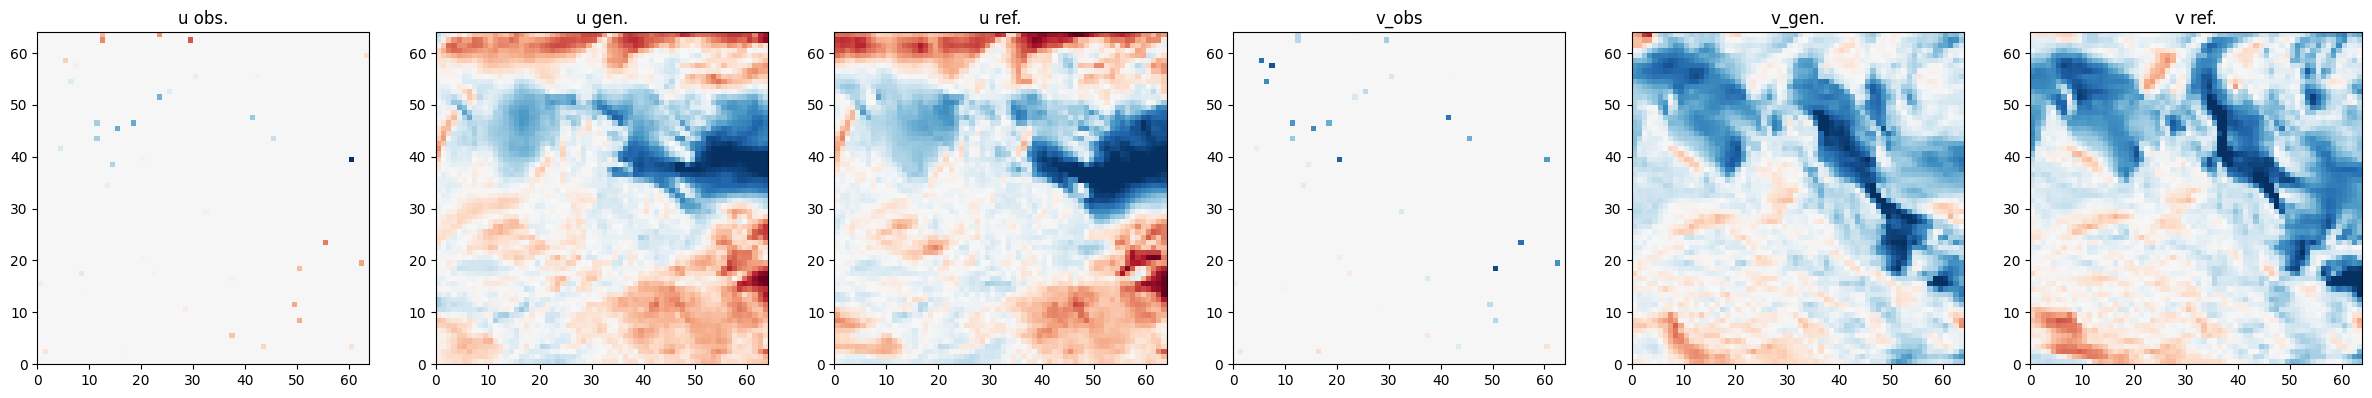

In [8]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
samples_noise = samples
if obs_type == 'forecast':
    data_plot = [x_pred[0, :, 0], samples[0, :, 0], x_pred[0, :, 1], samples[0, :, 1]]
    data_title = ['u gen.', 'u ref.', 'v_gen.', 'v ref.']
elif obs_type == 'regular':
    y_plot = np.zeros_like(x_pred)[..., ::scale, ::scale]
    y_plot[:, :T_prime_y, :2] = y
    data_plot = [y_plot[0, :, 0], x_pred[0, :, 0], samples[0, :, 0], y_plot[0, :, 1], x_pred[0, :, 1], samples[0, :, 1]]       
    data_title = ['u obs.', 'u gen.', 'u ref.', 'v_obs', 'v_gen.', 'v ref.']   # 'obs.', 
else:
    y_plot = np.zeros_like(x_pred)
    y_plot[:, :T_prime_y] = y
    data_plot = [y_plot[0, :, 0], x_pred[0, :, 0], samples[0, :, 0], y_plot[0, :, 1], x_pred[0, :, 1], samples[0, :, 1]]       
    data_title = ['u obs.', 'u gen.', 'u ref.', 'v_obs', 'v_gen.', 'v ref.']   # 'obs.',
vmins = [-3, -3, -3, -3, -3, -3]    # -3, 
vmaxs = [3, 3, 3, 3, 3, 3]      # 3, 
n_plot = len(data_plot)
def update(frame):
    plt.clf()  # Clear the current plot

    for i in range(n_plot):
        # Plot the first subplot
        plt.subplot(1, n_plot, i+1)
        plt.pcolormesh(data_plot[i][frame], cmap='RdBu_r', vmin=vmins[i], vmax=vmaxs[i])
        plt.title(data_title[i])
        plt.gca().set_aspect(1)

fig = plt.figure(figsize=(5*n_plot, 5))
ani = FuncAnimation(fig, update, frames=range(T_prime), repeat=False)
ani.save('./results/test_era5.gif', writer='pillow', fps=20)